In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [6]:
# Define the ticker symbol for the Shanghai Composite Index
ticker = '000001.SS'

# Define the date range
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download the full dataset sourced from yahoo finance
data = yf.download(ticker, start=start_date, end=end_date)

# Print some examples
print(pd.concat([data.head(1), data.tail(1)]))


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2014-01-02  2112.125977  2113.110107  2101.016113  2109.386963  2109.386963   
2023-12-29  2950.836914  2975.031982  2950.017090  2974.935059  2974.935059   

            Volume  
Date                
2014-01-02   68500  
2023-12-29  290700  


Train: 1944, Test: 487


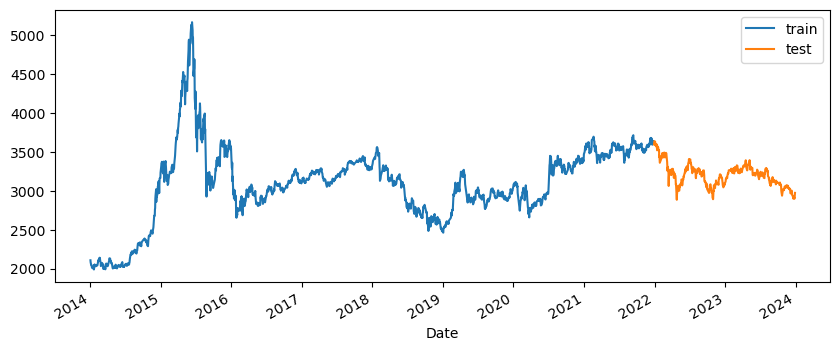

In [7]:
# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split train set and test set (0.8, 0.2)
train, test = train_test_split(X=data['Close'], size=0.8)
print(f'Train: {len(train)}, Test: {len(test)}')

# Plot train & test datasets 
fig, ax = plt.subplots(figsize=(10,4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.legend()
plt.show()

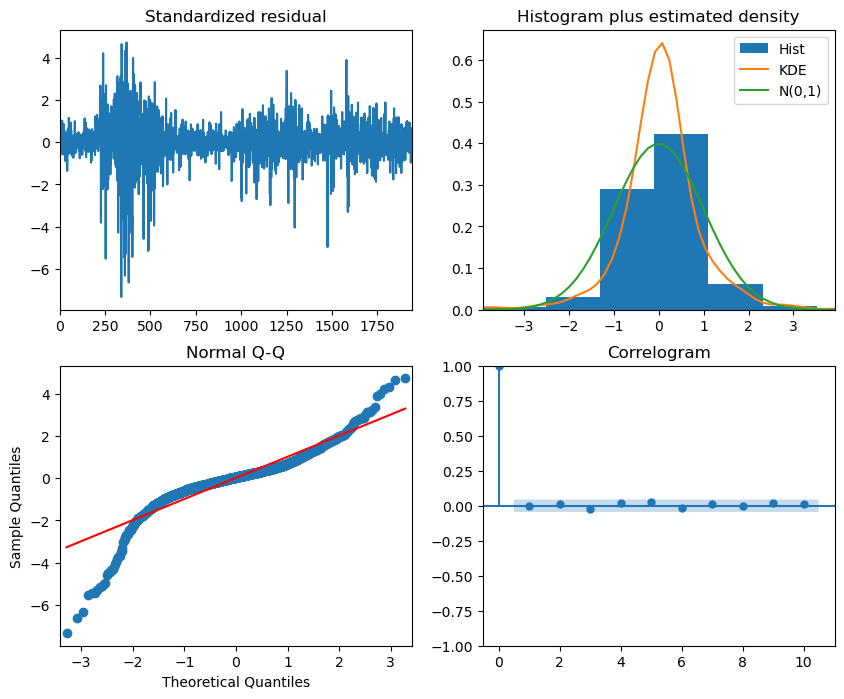

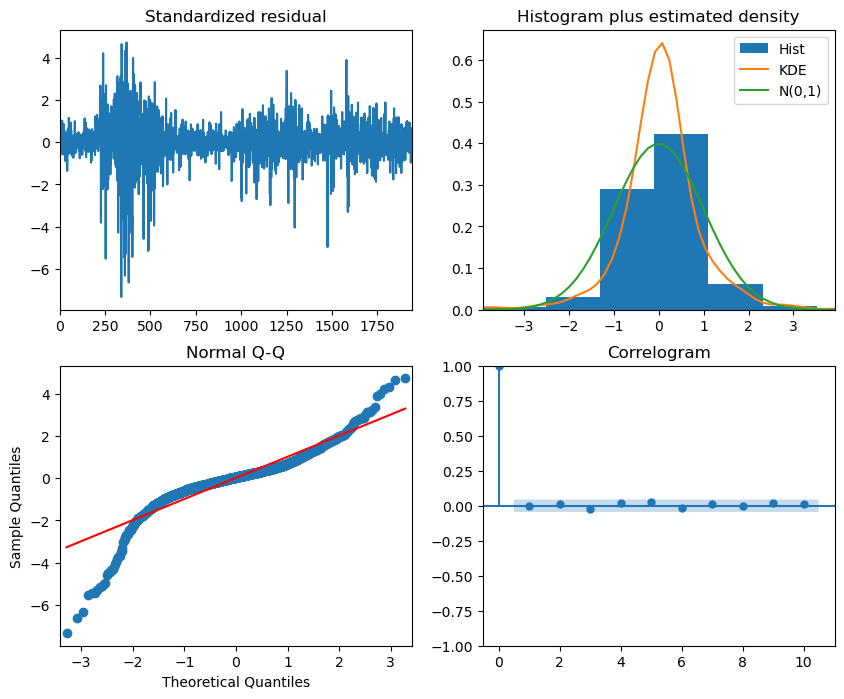

In [11]:
model = auto_arima(train, trace=False, error_action='ignore', suppress_warnings=True)

# Plot the residuals diagnostics
model.plot_diagnostics(figsize=(10, 8))

In [12]:
model

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [8]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

1-day Ahead Forecast:
MAE: 36.66475412455563
RMSE: 49.73279984484972
MAPE: 1.1512984283660088%



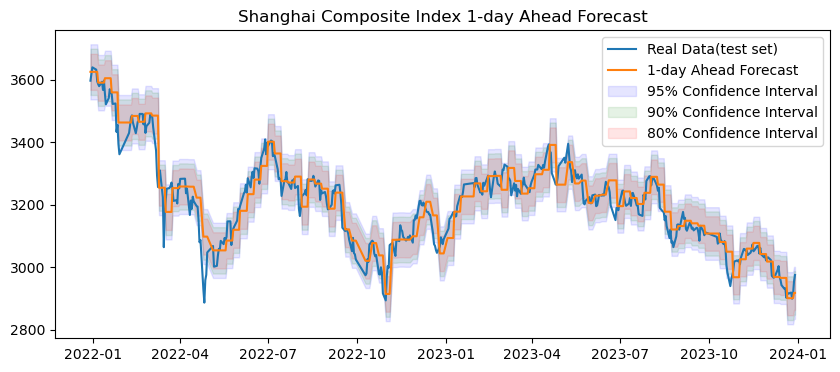

5-days Ahead Forecast:
MAE: 36.66098117166639
RMSE: 49.5617855762049
MAPE: 1.1505360399362652%



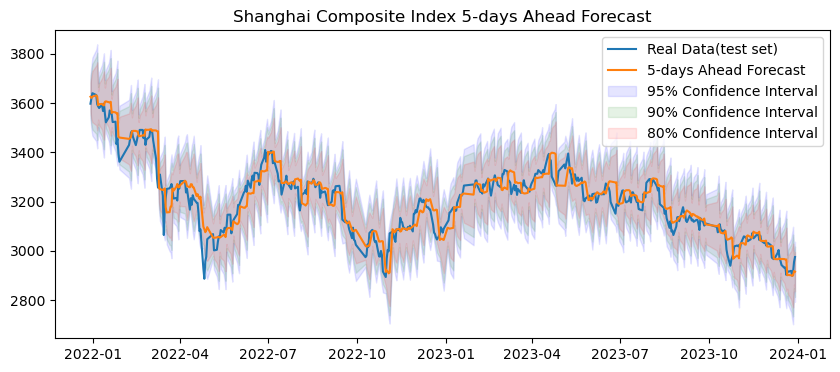

20-days Ahead Forecast:
MAE: 69.27498399902905
RMSE: 96.74519067777888
MAPE: 2.179779000820386%



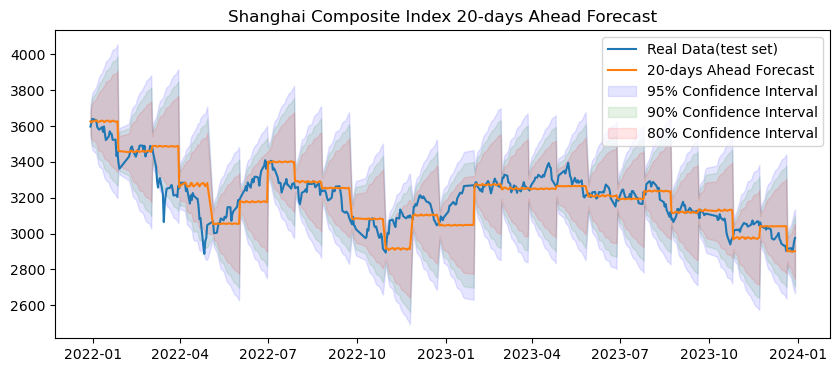

60-days Ahead Forecast:
MAE: 113.255817583232
RMSE: 146.42478888108013
MAPE: 3.541076918155337%



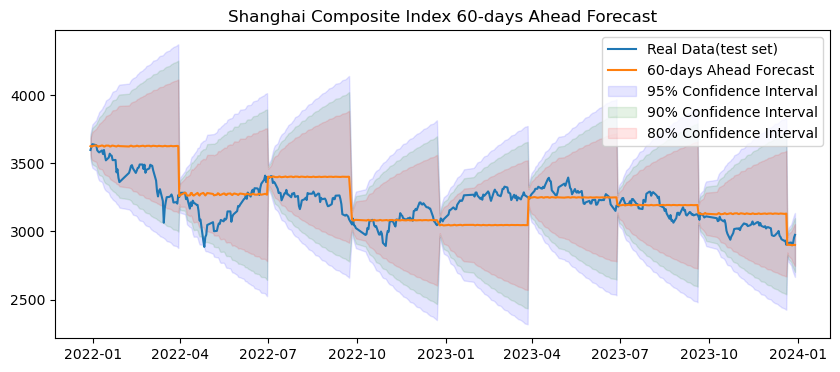

1-day Ahead Forecast:
MAE: 36.66475412455563
RMSE: 49.73279984484972
MAPE: 1.1512984283660088%

5-days Ahead Forecast:
MAE: 36.66098117166639
RMSE: 49.5617855762049
MAPE: 1.1505360399362652%

20-days Ahead Forecast:
MAE: 69.27498399902905
RMSE: 96.74519067777888
MAPE: 2.179779000820386%

60-days Ahead Forecast:
MAE: 113.255817583232
RMSE: 146.42478888108013
MAPE: 3.541076918155337%



In [9]:
# Function to perform multi-step forecast with specific confidence level
def multi_step_forecast(model, n_periods, alpha=0.05):
    arima_forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)
    return (
        arima_forecast.tolist(),
        np.asarray(conf_int).tolist()
    )

# Define a function for re-estimating ARIMA model with new data
def reestimate_arima_model(train_data):
    return auto_arima(train_data, trace=False, error_action='ignore', suppress_warnings=True)

# Perform forecasts and evaluations for different periods with re-estimation
forecast_periods = {'1-day': 1, '5-days': 5, '20-days': 20, '60-days': 60}
results = {}

for period_name, n_periods in forecast_periods.items():
    # Creat empty lists for storing results
    arima_predictions = []
    confidence_intervals_95 = []
    confidence_intervals_90 = []
    confidence_intervals_80 = []
    
    # Define the ARIMA model for each time horizon
    current_train = train.copy()
    arima_model = reestimate_arima_model(current_train)
    
    # For daily forecast, we choose to re-estimate parameters every 5 forecasts
    reestimate_interval = 5 if period_name == '1-day' else 1
    forecasts_since_last_reestimate = 0
    
    for i in range(0, len(test), n_periods):
        # Perform multi-step forecast
        arima_forecast_95, conf_95 = multi_step_forecast(arima_model, n_periods, alpha=0.05)
        arima_forecast_90, conf_90 = multi_step_forecast(arima_model, n_periods, alpha=0.10)
        arima_forecast_80, conf_80 = multi_step_forecast(arima_model, n_periods, alpha=0.20)

        for j in range(n_periods):
            if i + j < len(test):
                # Store results
                arima_predictions.append(arima_forecast_95[j])
                confidence_intervals_95.append(conf_95[j])
                confidence_intervals_90.append(conf_90[j])
                confidence_intervals_80.append(conf_80[j])

        # Update the training sets with new observed data
        current_train = pd.concat([current_train, test[i:i+n_periods]])
        
        # Re-estimate the ARIMA model with the updated training sets
        forecasts_since_last_reestimate += 1
        if forecasts_since_last_reestimate >= reestimate_interval:
            arima_model = reestimate_arima_model(current_train)
            forecasts_since_last_reestimate = 0

    # Sort ARIMA Forecasts
    arima_forecast_series = pd.Series(arima_predictions[:len(test)], index=test.index[:len(arima_predictions)])
    conf_int_df_95 = pd.DataFrame(confidence_intervals_95[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_90 = pd.DataFrame(confidence_intervals_90[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_80 = pd.DataFrame(confidence_intervals_80[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    final_forecast = arima_forecast_series

    # Evaluate the Forecast
    mae = mean_absolute_error(test[:len(arima_predictions)], final_forecast)
    rmse = np.sqrt(mean_squared_error(test[:len(arima_predictions)], final_forecast))
    mape = np.mean(np.abs((test[:len(arima_predictions)] - final_forecast) / test[:len(arima_predictions)])) * 100

    # Store results
    results[period_name] = {
        'forecast': final_forecast,
        'confidence_intervals_95': conf_int_df_95,
        'confidence_intervals_90': conf_int_df_90,
        'confidence_intervals_80': conf_int_df_80,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    # Print the evaluation metrics
    print(f'{period_name.capitalize()} Ahead Forecast:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%\n')

    # Plot the results
    plt.figure(figsize=(10, 4))
    plt.plot(test, label='Real Data(test set)')
    plt.plot(final_forecast, label=f'{period_name.capitalize()} Ahead Forecast')

    # Plot different confidence intervals with different colors
    plt.fill_between(conf_int_df_95.index, conf_int_df_95['lower'], conf_int_df_95['upper'], color='b', alpha=0.1, label='95% Confidence Interval')
    plt.fill_between(conf_int_df_90.index, conf_int_df_90['lower'], conf_int_df_90['upper'], color='g', alpha=0.1, label='90% Confidence Interval')
    plt.fill_between(conf_int_df_80.index, conf_int_df_80['lower'], conf_int_df_80['upper'], color='r', alpha=0.1, label='80% Confidence Interval')

    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast')
    plt.legend()
    plt.show()

# Summarize results for each forecasting period
for period_name, result in results.items():
    print(f"{period_name.capitalize()} Ahead Forecast:")
    print(f"MAE: {result['mae']}")
    print(f"RMSE: {result['rmse']}")
    print(f"MAPE: {result['mape']}%\n")